# Code for dissertation by YUYAO XU

In [8]:
#import libraries

import numba as nb
import numpy as np
import scipy.spatial as spat
import os 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime
from scipy import optimize
from matplotlib import pyplot as plt, cm, colors

In [2]:
#function of extracting the triangulation of alpha shape of point cloud

@nb.jit
def nb_dot(x, y):
    val = 0
    for x_i, y_i in zip(x, y):
        val += x_i * y_i
    return val

@nb.jit
def nb_cross(x, y):
    val = np.array([  x[1]*y[2] - x[2]*y[1],
             x[2]*y[0] - x[0]*y[2],
             x[0]*y[1] - x[1]*y[0] ])
    return val

@nb.jit
def r2_circumsphere_tetrahedron_single(a, b, c, d):
    ad = a - d
    bd = b - d
    cd = c - d

    ad2 = nb_dot(ad, ad)
    bd2 = nb_dot(bd, bd)
    cd2 = nb_dot(cd, cd)

    cross_1 = nb_cross(bd, cd)
    cross_2 = nb_cross(cd, ad)
    cross_3 = nb_cross(ad, bd)

    q = ad2 * cross_1 + bd2 * cross_2 + cd2 * cross_3
    p = 2 * np.abs( nb_dot(ad, cross_1) )
    if p < 1e-10:
        return np.infty
    
    r2 = nb_dot(q, q) / p**2

    return r2

@nb.jit(nopython=True)
def r2_circumsphere_tetrahedron(a, b, c, d):
    len_a = len(a)
    r2 = np.zeros((len_a,))
    for i in range(len_a):
        r2[i] = r2_circumsphere_tetrahedron_single(a[i], b[i], c[i], d[i])
    return r2

@nb.jit
def get_faces(tetrahedron):
    faces = np.zeros((4, 3))
    for n, (i1, i2, i3) in enumerate([(0, 1, 2), (0, 1, 3), (0, 2, 3), (1, 2, 3)]):
        faces[n] = tetrahedron[i1], tetrahedron[i2], tetrahedron[i3]
    return faces

def get_single_faces(triangulation):
    num_faces_single = 4
    num_tetrahedrons = triangulation.shape[0]
    num_faces = num_tetrahedrons * num_faces_single
    faces = np.zeros((num_faces, 3), np.int_) # 3 is the dimension of the model
    mask = np.ones((num_faces,), np.bool_)
    for n in range(num_tetrahedrons):
        faces[num_faces_single * n: num_faces_single * (n+1)] = get_faces(triangulation[n])
    orderlist = ["x{}".format(i) for i in range(faces.shape[1])]
    dtype_list = [(el, faces.dtype.str) for el in orderlist]
    faces.view(dtype_list).sort(axis=0)
    for k in range(num_faces-1):
        if mask[k]:
            if np.all(faces[k] == faces[k+1]):
                mask[k] = False
                mask[k+1] = False
    single_faces = faces[mask]
    return single_faces

def get_alpha_shape(pointcloud, alpha):

    pointcloud = np.asarray(pointcloud)
    assert pointcloud.ndim == 2
    assert pointcloud.shape[1] == 3, "for now, only 3-dimensional analysis is implemented"

    triangulation = spat.Delaunay(pointcloud)

    tetrahedrons = pointcloud[triangulation.simplices] # remove this copy step, could be fatal
    radii2 = r2_circumsphere_tetrahedron(tetrahedrons[:, 0, :], tetrahedrons[:, 1, :], tetrahedrons[:, 2, :], tetrahedrons[:, 3, :])
    reduced_triangulation = triangulation.simplices[radii2 < alpha**2]
    del radii2, triangulation, tetrahedrons

    outer_triangulation = get_single_faces(reduced_triangulation)

    return outer_triangulation


In [3]:
#function for reading print cloud
@nb.jit
def array_cloud (filename): 
    f = open(filename,'r')
    point = f.read() #read all the point data from selected file
    f.close()
    l2 = point.split('\n') 
    l2.pop()
    m0 = np.array(l2)
    m1 = np.empty((len(l2),3))
    for item in range(len(l2)):
        n = np.array(m0[item].split(' '))
        m1[item] = n
    return m1

In [4]:
#function of plotting point cloud
def print_cloud (points): 
    x,y,z= np.hsplit(points,3)
    fig=plt.figure(dpi=120)
    ax=fig.add_subplot(111,projection='3d')
    plt.title('point cloud')
    ax.scatter(x,y,z,c='b',marker='.',s=2,linewidth=0,alpha=1,cmap='spectral')
    ax.axis('scaled')          
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    plt.show()

In [34]:
#function of creating the point cloud of alpha shape

def alpha_point(original_cloud, alpha_tri):
    point_set = set()
    
    for item in alpha_tri:
        a = item[0]
        b = item[1]
        c = item[2]
        point_set.add(a)
        point_set.add(b)
        point_set.add(c)
        
    point_list = list(point_set)
    
    alpha_point_array = np.empty((len(point_list),3))
    
    for index in range (len(point_list)):
        n = np.array(original_cloud[point_list[index]])
        alpha_point_array[index] = n
        
    del point_set, point_list
    
    return alpha_point_array

In [6]:
#function for writting point cloud into txt files with ','
@nb.jit
def write_cloud(cloud, filename):
    with open(filename+'.txt','w') as fw:
        for coo in cloud:
            a = str(coo[0])
            b = str(coo[1])
            c = str(coo[2])
            context = a+","+b+','+c+'\n'
            fw.write(context)
        file.close 
    print filename + 'has been written.'

In [7]:
def write_alpha_points (inputfile, alpha_value, outputfile):
    point_cloud = array_cloud(inputfile)
    alpha_tri = get_alpha_shape(point_cloud, alpha_value)
    alpha_points = alpha_point(point_cloud, alpha_tri)
    write_cloud(alpha_points, outputfile)

In [18]:
#functions for finding least Squares circle

def calc_R(x,y, xc, yc):
    """ calculate the distance of each 2D points from the center (xc, yc) """
    return np.sqrt((x-xc)**2 + (y-yc)**2)

def f(c, x, y):
    """ calculate the algebraic distance between the data points and the mean circle centered at c=(xc, yc) """
    Ri = calc_R(x, y, *c)
    return Ri - Ri.mean()

def leastsq_circle(x,y):
    # coordinates of the barycenter
    x_m = np.mean(x)
    y_m = np.mean(y)
    center_estimate = x_m, y_m
    center, ier = optimize.leastsq(f, center_estimate, args=(x,y))
    xc, yc = center
    Ri       = calc_R(x, y, *center)
    R        = Ri.mean()
    residu   = np.sum((Ri - R)**2)
    return xc, yc, R, residu

def plot_data_circle(x,y, xc, yc, R):
    f = plt.figure( facecolor='white')  #figsize=(7, 5.4), dpi=72,
    plt.axis('equal')

    theta_fit = np.linspace(-pi, pi, 180)


    plt.xlabel('x')
    plt.ylabel('y')   
    # plot data
    plt.scatter(x, y, c = 'red',label='data')
    x_fit = xc + R*np.cos(theta_fit)
    y_fit = yc + R*np.sin(theta_fit)
    plt.plot(x_fit, y_fit, 'b-' , label="fitted circle", lw=2)
    plt.plot([xc], [yc], 'bD', mec='y', mew=1)

    plt.legend(loc='best',labelspacing=0.1 )
    plt.grid()
    plt.title('Least Squares Circle')

In [9]:
#calculate the perimeter of circle
def cir_cal(R):
    val = 2*(3.14)*R
    return val

In [38]:
#find the DBH of a tree

def DBH(pointcloud):
    z = pointcloud[:,2]
    height = np.max(z)-np.min(z)
    ground = np.min(z)
    DBHup = ground + 1.35
    DBHdown = ground + 1.25
    DBH_point_list = []
    for item in pointcloud:
        if item[2]>DBHdown and item[2]<DBHup:
            DBH_point_list.append([item[0],item[1]])
    DBH_point_array = np.array(DBH_point_list)
    circle_paras = leastsq_circle(DBH_point_array[:,0],DBH_point_array[:,1])
    val = 2 * circle_paras[2]
    return val
            

In [12]:
#find the trunk height
@nb.jit
def trunk_height(pointcloud):
    DBH_pointcloud = DBH(pointcloud)
    height = np.max(pointcloud[:,2])-np.min(pointcloud[:,2])
    ground = np.min(pointcloud[:,2])
    n = 0
    level_list = []
    Rlist = []
    for level in range(0,50):
        x_y_collect = []
        low = ground + n * (height/50)
        up = ground+ (n+1) * (height/50)
        
        for point in pointcloud:
            if point[2] > low and point[2] < up:
                x_y_collect.append([point[0],point[1]])
        x_y_array = np.array(x_y_collect)
        circle_paras = leastsq_circle (x_y_array[:,0],x_y_array[:,1])
        Rlist.append(circle_paras[2])
        if n>1:
            diff = Rlist[-1]-Rlist[-2]
            if diff > 0.25*DBH_pointcloud:
                level_list.append(n)
        n = n + 1
    z = ground + level_list[0] * (height/50)
    return z

In [26]:
#seprate the trunk and crown of daa
@nb.jit
def sep_trunk(pointcloud,alpha_pointcloud,crown_name):
    height_trunk = trunk_height(pointcloud)
    trunk = pointcloud[np.where(pointcloud[:,2]<=height_trunk)]
    crown = alpha_pointcloud[np.where(alpha_pointcloud[:,2]>height_trunk)]
    write_cloud(crown, crown_name)
    return trunk, crown   

In [17]:
#find the centroid of a 2D print cloud
@nb.jit
def centroid(a,b):
    size = a.size
    x = np.sum(a)/size
    y = np.sum(b)/size
    return [x,y]

In [21]:
#identify the shape of crown
@nb.jit
def crown_shape(crown_cloud):
    z = crown_cloud[:,2]
    crown_height = np.max(z)-np.min(z)
    h = 0.05*crown_height
    crown_down = np.min(z)
    crown_up = np.max(z)
    mid_height = 0.5*crown_height + crown_down
    up = crown_cloud(np.where[crown_cloud[:,2]>=(crown_up-h)])
    mid = crown_cloud(np.where[crown_cloud[:,2]<=(mid_height+h/2)and crown_cloud[:,2]>=(mid_height-h/2)])
    down = crown_cloud(np.where[crown_cloud[:,2]<=(crown_down+h)])
    
    u = leastsq_circle(up[:,0],up[:,1])
    ur = u[2]
    m = leastsq_circle(mid[:,0],mid[:,1])
    mr = m[2]
    d = leastsq_circle(down[:,0],down[:,1])
    dr = d[2]
    
    if dr>mr and mr>ur:
        tag = 'conical'
    if dr<mr and mr<ur:
        tag = 'inverse conical'
    if mr>dr and mr>ur:
        tag = 'spherical'
    else:
        tag = 'cylindrial'
    
    return ur,mr,dr,tag
        

In [22]:
@nb.jit
def distan(a, b):
    x = a[0]-b[0]
    y = a[1]-b[1]
    z = a[2]-b[2]
    var = (x^2 + y^2 + z^2)^(0.5)
    return var
    

In [24]:
#identify the curve of trunk
@nb.jit
def curve_trunk(trunk_cloud):
    z = trunk_cloud[:,2]
    height_trunk = np.max(z) - np.min(z)
    h = 0.1 * height_trunk
    base = np.min(z)
    
    centre = []
    for i in range(0,10):
        base = base + i * h
        cross = base + (i+1)*h
        collect = trunk_cloud(np.where[trunk_cloud[:,2]>=base and trunk_cloud[:,2]<=cross])
        circle = leastsq_circle(collect[:,0],collect[:,1])
        z_c = (base+cross)/2
        centre.append([circle[0],circle[1],z_c])
    dis = 0
    for n in range(len(centre)-1):
        gap = distan(centre[n],centre[n+1])
        dis += gap
    c = dis/height_trunk
    return c

In [73]:
def crown_width(crown_cloud):
    x = crown_cloud[:,0]
    y = crown_cloud[:,1]
    xy = np.empty((crown_cloud.size/3, 2))
    xy[:,0] = x
    xy[:,1] = y
    hull = spat.ConvexHull(xy)
    point_set = np.empty((hull.vertices.size,2))
    for i in range(hull.vertices.size):
        n = np.array(xy[hull.vertices[i]])
        point_set[i] = n
    R = leastsq_circle(point_set[:,0],point_set[:,1])
    return R
        
        
    
    

In [27]:
rs2 = array_cloud('E:/russel/clouds/rs_2.txt')

In [28]:
alrs2 = get_alpha_shape(rs2,1)

In [36]:
al_rs2 = alpha_point(rs2,alrs2)

In [43]:
xy = np.empty((40429,2))

In [44]:
xy[:,0] = al_rs2[:,0]

In [46]:
xy[:,1] = al_rs2[:,1]

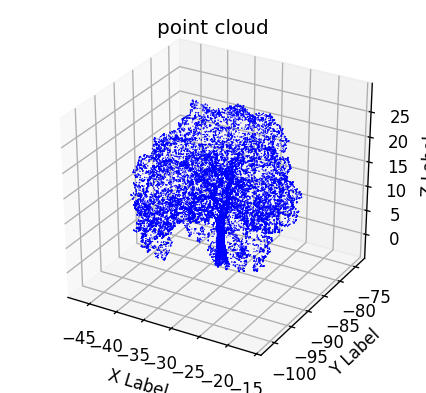

In [45]:
print_cloud(al_rs2)

In [49]:
conv = spat.ConvexHull(xy)

In [53]:
alla = leastsq_circle(conv.points[:,0],conv.points[:,1])

In [66]:
conv.vertices[0]

24313

In [57]:
pi = 3.14

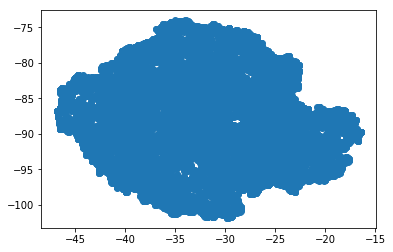

In [64]:
plt.scatter(conv.points[:,0],conv.points[:,1])

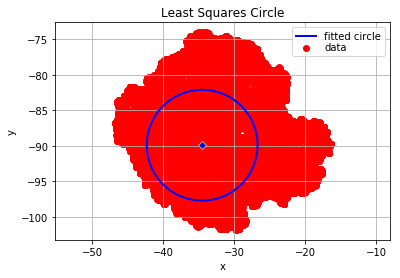

In [58]:
plot_data_circle(conv.points[:,0],conv.points[:,1],alla[0],alla[1],alla[2])

In [74]:
wd = crown_width(al_rs2)

In [75]:
print wd

(-31.796581861327045, -88.163526076019281, 14.217116132341671, 34.290725727168123)


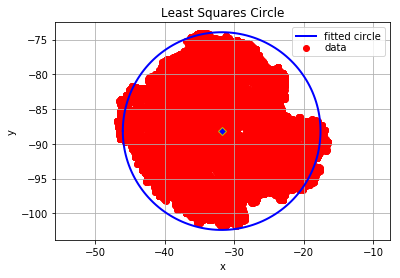

In [76]:
plot_data_circle(conv.points[:,0],conv.points[:,1],wd[0],wd[1],wd[2])